#MIT 6.036 Fall 2021: Lab 5
## Features

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

import json
import pandas as pd

#2) 3-Block Tetris revisited

Let's re-visit the 3-block tetris example from Lab 4. We were unable to train a linear classifier that could perfectly classify Lines and Corners on our 3x3 gameboard when trained on a 9D vector representing which pixels on our gameboard were occupied (1) or not (0). This was because Lines with a center pixel could not be separated from Corners centered on the gameboard with.

In this problem, we will craft another set new set of features to remedy the classifier's performance. We will also standardize our data (i.e. shifting by mean and scaling by standard deviation) and explore the impact of regularization on solutions found from minimizing the negative log likelihood loss.

Let's plot the dataset to remind ourselves of the different shapes.

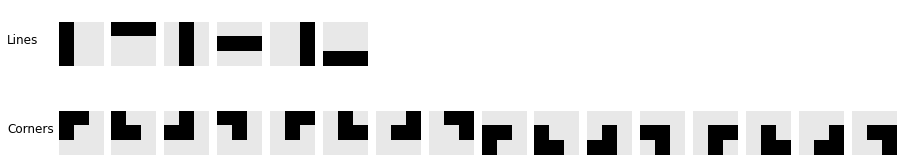

In [3]:
### Create the dataset

empty = np.zeros((3, 3))

# Line pieces (6)
lines = []
for i in range(3):
    line_vert, line_horz = empty.copy(), empty.copy()
    line_horz[i, :] = 1
    line_vert[:, i] = 1
    lines += [line_vert, line_horz]

# L pieces (8)
corners = []
for i in range(2):
  for j in range(2):
    corner1, corner2, corner3, corner4  = empty.copy(), empty.copy(), empty.copy(), empty.copy()
    corner1[[i, i, i+1], [j, j+1, j]] = 1
    corner2[[i, i+1, i+1], [j, j+1, j]] = 1
    corner3[[i+1, i+1, i], [j, j+1, j+1]] = 1
    corner4[[i, i, i+1], [j, j+1, j+1]] = 1
    corners += [corner1, corner2, corner3, corner4]

### Plot the dataset
fig, ax = plt.subplots(nrows=2, ncols=len(corners), figsize=(15,3))
vmin = -0.1  # So empyt shows up as grey 
cmap = 'binary'
for i in range(len(corners)):
  ax[0, i].axis('off')
  ax[1, i].axis('off')
  try:
      ax[0, i].imshow(lines[i], cmap=cmap, vmin=vmin)
  except:
      pass
  ax[1, i].imshow(corners[i], cmap=cmap, vmin=vmin)

ax[0, 0].text(-4, 1, "Lines", fontsize=12)
ax[1, 0].text(-4, 1, "Corners", fontsize=12);

Again we'll use the `sklearn.linear.LogisticRegression` model. We'll regularize the model by adding the term $\lambda||\theta||^2$ to our objective function with a strength of $\lambda = 1$ (these are the defaults for `sklearn.linear.LogisticRegression`).

In [4]:
import sklearn
import sklearn.linear_model

images = np.concatenate([lines, corners], axis=0)
shapes = images.reshape(-1, 9)  # Flatten 2D 3x3 data into vector
labels = np.array([0,] * len(lines) + [1,] * len(corners))
N = labels.shape[0]

In [6]:
### Plotting functions ####

def get_groups(decisions):
  unique_decisions = np.sort(np.unique(decisions.round(decimals=4)))
  argwhere_unique_decisions = np.argwhere(decisions.round(decimals=4).reshape(-1, 1) == unique_decisions.reshape(1, -1))
  line_groups = []
  corner_groups = []
  for i, d in enumerate(unique_decisions):
    line_groups.append(np.logical_and(argwhere_unique_decisions[:, 1] == i, labels == 0).nonzero()[0])
    corner_groups.append(np.logical_and(argwhere_unique_decisions[:, 1] == i, labels == 1).nonzero()[0])
  return unique_decisions, line_groups, corner_groups

def imscatter(x, y, shape, ax=None, zoom=1, cmap="binary", vmin=-0.1, vmax=1.0,):
  if ax is None:
      ax = plt.gca()
  im = OffsetImage(shape, zoom=zoom, cmap=cmap)
  x, y = np.atleast_1d(x, y)
  artists = []
  for x0, y0 in zip(x, y):
      ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
      artists.append(ax.add_artist(ab))
  ax.update_datalim(np.column_stack([x, y]))
  ax.autoscale()
  return artists

def plot_decisions(decisions, cols=4, xlim=2.5):
  unique_decisions, line_groups, corner_groups = get_groups(decisions)

  # xlim = np.abs(unique_decisions).max()

  fig, ax = plt.subplots(1, 1, figsize=(15,7.5))

  n_ticks = 13
  ax.eventplot(np.linspace(-xlim, xlim, n_ticks), orientation='horizontal', colors="#808080",
              lineoffsets=0, linelengths=0.1, linewidths=2,)
  ax.plot([0, 0], [-xlim, xlim], '--', color="#808080")
  ax.plot([-xlim, xlim], [0, 0], '-', color="#808080")

  viridis = ['#fde725', "#5ec962", "#3b528b", "#440154"] * 2
  viridis = viridis[:len(unique_decisions)]
  lighter_viridis = ['#f7efa6', "#b5e8b7", "#8a9ed1", "#cf7be3"] * 2
  lighter_viridis = lighter_viridis[:len(unique_decisions)]

  ax.scatter(unique_decisions, np.zeros_like(unique_decisions), c=viridis, s=100, zorder=100)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.axes.get_xaxis().set_visible(False)

  imshow_size_w = 0.4
  imshow_size_h = imshow_size_w * 0.4
  spacing_x = 0.175
  spacing_y = 0.125
  shift_x = - imshow_size_w / 4
  shift_y = 0.2
  zoom = 7

  for lg, cg, v in zip(line_groups, corner_groups, lighter_viridis):
    cmap = LinearSegmentedColormap.from_list('shifted_binary', [v, "#000000"], N=2)
    for i, s in enumerate(lg):
      imscatter(decisions[s] + (i % cols) * spacing_x + shift_x, -shift_y - (i // cols) * spacing_y, shapes[s].reshape(3, 3),
                ax=ax, zoom=zoom, cmap=cmap)
    for i, s in enumerate(cg):
      imscatter(decisions[s] + (i % cols) * spacing_x + shift_x, shift_y + (i // cols) * spacing_y, shapes[s].reshape(3, 3),
                ax=ax, zoom=zoom, cmap=cmap)

  ax.set_ylim(-1, 1)

  offset_y = -0.1
  for i in np.linspace(-xlim, xlim, n_ticks):
      ax.annotate('%.1f' % i, (i, offset_y), ha="center", va="center")

  ax.annotate(r"$\theta^T x + \theta_0$", (-xlim, -0.2), fontsize=20, ha="center", va="center")

  label_x = xlim / 2
  label_y = 1
  ax.annotate(r"Correctly Classified as Corner", (label_x, label_y), fontsize=20, ha="center", va="center", color="#588c5b")
  ax.annotate(r"Correctly Classified as Line", (-label_x, -label_y), fontsize=20, ha="center", va="center", color="#588c5b")
  ax.annotate(r"Misclassified as Line", (-label_x, +label_y), fontsize=20, ha="center", va="center", color="#eb7171")
  ax.annotate(r"Misclassified as Corner", (label_x, -label_y), fontsize=20, ha="center", va="center", color="#eb7171")

  ax.annotate(r"Corners", (-xlim - 0.1, 0.5), fontsize=26, ha="center", va="center", rotation=90, color="#b3b3b3")
  ax.annotate(r"Lines", (-xlim - 0.1, -0.5), fontsize=26, ha="center", va="center", rotation=90, color="#b3b3b3")

  return fig

def plot_rows_cols(rows_data, cols_data, vmax, title, vmin=0):
  fig = plt.figure(figsize=(10, 2.5))
  n = 4

  samples = [0, 4, 10, 18]
  gs = gridspec.GridSpec(4, 4 * n, figure=fig)
  for i, s in zip(range(n), samples):
    ax_cols = fig.add_subplot(gs[0, (4*i+1):(4*i+3)])
    ax_shape = fig.add_subplot(gs[1:3, (4*i+1):(4*i+3)])
    ax_rows = fig.add_subplot(gs[1:3, 4*i])
    ax_shape.imshow(images[s], cmap='binary', vmin=-0.1)
    ax_cols.imshow(rows_data[s].reshape(1, -1), cmap='plasma', vmin=vmin, vmax=vmax)
    im = ax_rows.imshow(cols_data[s].reshape(-1, 1), cmap='plasma', vmin=vmin, vmax=vmax)
    for ax in [ax_shape, ax_cols, ax_rows]:
      ax.axis('off')

  fig.subplots_adjust(bottom=0.1)
  cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
  fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
  fig.suptitle(title, fontsize=14);

Let's try crafting a new set of features that will help our linear logistic classifier distinguish our tetris blocks. How about instead of giving the model which pixels are occupied or not, we sum how many pixels are occupied in each of the 3 rows and each of the 3 columns?

In [7]:
#@title
def sum_rows_and_cols(images):
  sum_rows = images.sum(axis=-2)
  sum_cols = images.sum(axis=-1)
  return np.concatenate([sum_rows, sum_cols], axis=-1)

In [8]:
sum_rows = images.sum(axis=-2)
sum_cols = images.sum(axis=-1)

sum_data = sum_rows_and_cols(images)

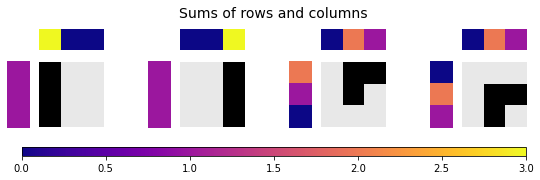

In [9]:
plot_rows_cols(sum_rows, sum_cols, 
               vmax=3, title="Sums of rows and columns")

Alright! Time to train!

In [10]:
sample_weight = None

data = sum_data

clf = sklearn.linear_model.LogisticRegression(penalty='l2', C=1, random_state=45).fit(data, labels, sample_weight=sample_weight)
print("Model accuracy: %.3g" % clf.score(data, labels))
decisions = clf.decision_function(data)

Model accuracy: 0.909


2A) Now let's look at results from the model we've trained. Which shapes are being misclassified?

In [11]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap

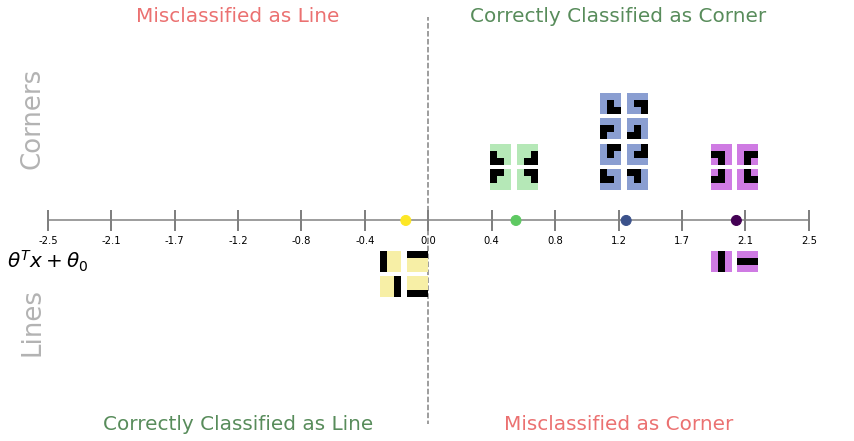

In [12]:
fig = plot_decisions(decisions, cols=2)

Okay, so our new features in `sum_data` were still not enough to separate our classes. We are having lines predicted with the same $\theta^T x + \theta_0$ as corners. What if we instead use terms that are square of `sum_data`?

In [13]:
sum_data_second_order = np.concatenate([sum_rows **2, sum_cols ** 2], axis=-1)

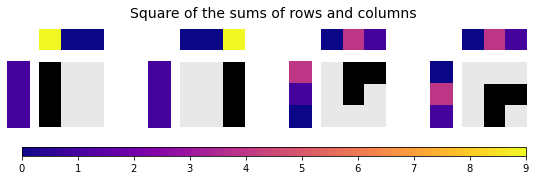

In [14]:
plot_rows_cols(sum_data_second_order[:, :3], sum_data_second_order[:, 3:], 
               vmax=9, title="Square of the sums of rows and columns")

In [15]:
sample_weight = None

data = sum_data_second_order

clf = sklearn.linear_model.LogisticRegression(penalty='l2', C=1, random_state=45).fit(data, labels, sample_weight=sample_weight)
print("Model accuracy: %.3g" % clf.score(data, labels))
decisions = clf.decision_function(data)

Model accuracy: 0.909


At first, this seems like these features are no better! But, let's plot the decisions for different groups.

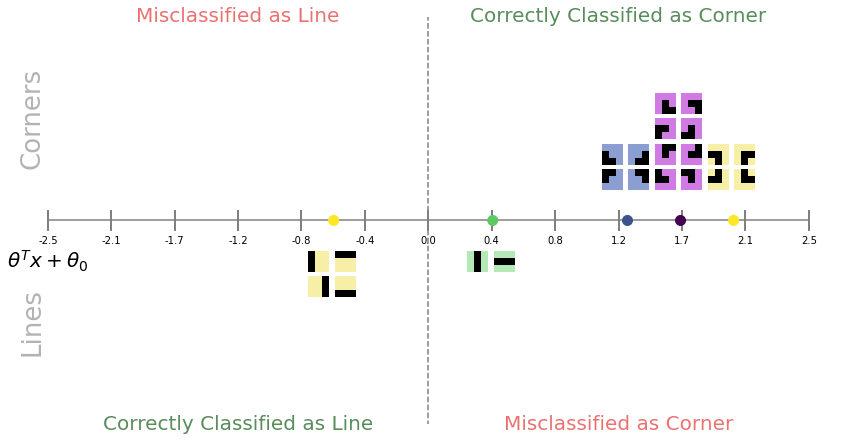

In [16]:
fig = plot_decisions(decisions, cols=2)

Ah ha! Still not perfect. But now all the shapes that are being grouped together are at least of the same class, so there is hope! We can see that some of the lines are still being missclassified as above the desicion boundary.

Now, we could try re-weighing our examples like we did in Lab 04. We could also notice that our regularization strength is also likely play a role here. What happens if we weaken our regularization by a factor of 10? (Note, that our model uses $C = 1 /\lambda$)

In [17]:
sample_weight = None

data = sum_data_second_order

clf = sklearn.linear_model.LogisticRegression(penalty='l2', C=10, random_state=45).fit(data, labels, sample_weight=sample_weight)
print("Model accuracy: %.3g" % clf.score(data, labels))
decisions = clf.decision_function(data)

Model accuracy: 1


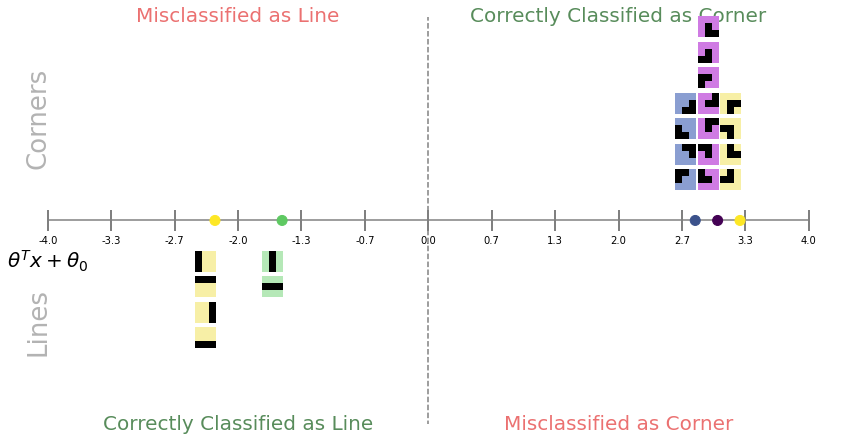

In [18]:
fig = plot_decisions(decisions, xlim=4.0, cols=1)

Bingo! Now let's plot the parameters $\theta$ and $\theta_0$. Here, we are concatenating $\theta_0$ to $\theta$.

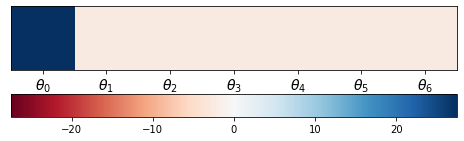

In [19]:
coef_and_offset = np.concatenate([clf.intercept_.reshape(1, -1), clf.coef_.reshape(1, -1)], axis=-1)

fig = plt.figure(figsize=(8, 3))
im = plt.imshow(coef_and_offset, cmap='RdBu', vmax=np.abs(coef_and_offset).max(), vmin=-np.abs(coef_and_offset).max())
ax = fig.axes[0]
ax.set_yticks([])
ax.set_xticks(list(range(7)))
ax.set_xticklabels([r"$\theta_{}$".format(i) for i in range(7)], fontsize=14)
plt.colorbar(im, orientation="horizontal");

It looks like all the values of $\theta$ are very similar which means that all that $\theta^T x$ is **almost** doing the same thing as summing over $x$ and multiplying by a constant. Let's see if we can simplify our features even more! We will simply give the model the mean of the square of the sums of the rows in columns...

In [20]:
# Summarize 6 inputs in 1
sum_data_second_order_mean = sum_data_second_order.mean(axis=1, keepdims=True)

In [21]:
sample_weight = None

data = sum_data_second_order_mean

clf = sklearn.linear_model.LogisticRegression(penalty='l2', C=10, random_state=45).fit(data, labels, sample_weight=sample_weight)
print("Model accuracy: %.3g" % clf.score(data, labels))
decisions = clf.decision_function(data)

Model accuracy: 1


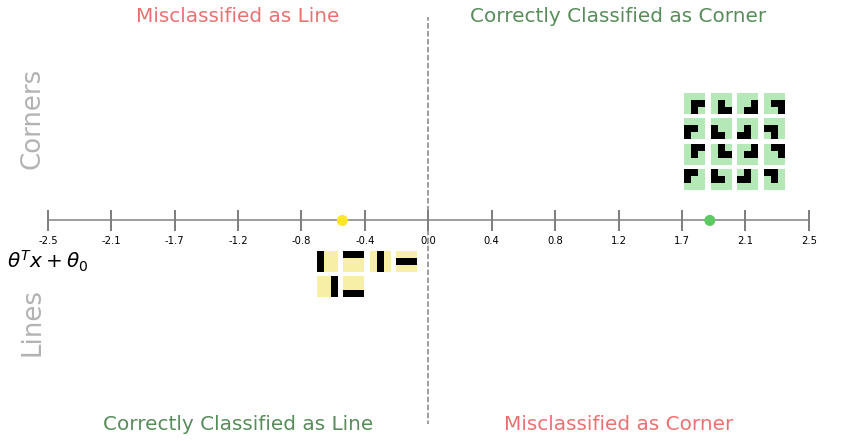

In [ ]:
fig = plot_decisions(decisions, cols=4)

[[13.92643731 -7.24586956]]


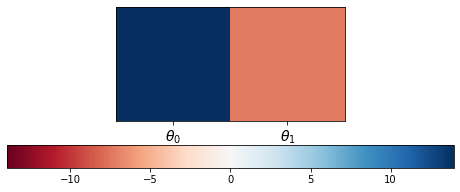

In [22]:
coef_and_offset = np.concatenate([clf.intercept_.reshape(1, -1), clf.coef_.reshape(1, -1)], axis=-1)
print(coef_and_offset)
d = 1

fig = plt.figure(figsize=(8, 3))
im = plt.imshow(coef_and_offset, cmap='RdBu', vmax=np.abs(coef_and_offset).max(), vmin=-np.abs(coef_and_offset).max())
ax = fig.axes[0]
ax.set_yticks([])
ax.set_xticks(list(range(d + 1)))
ax.set_xticklabels([r"$\theta_{}$".format(i) for i in range(d + 1)], fontsize=14)
plt.colorbar(im, orientation="horizontal");